# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [320]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = '1_dia' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_1_dia_limpio.csv
Rango de fechas: 2022-07-25 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,1,136.88,2022-07-25,1.0
1,3,354.00,2022-07-28,3.0
2,2,236.00,2022-07-29,2.0
3,9,1062.00,2022-08-02,9.0
4,2,236.00,2022-08-08,2.0


In [321]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,1214.000000,1214.000000,1214,1214.000000
mean,298.138386,36066.738278,2024-04-02 11:14:55.551894784,186.354201
min,1.000000,118.000000,2022-07-25 00:00:00,1.000000
25%,131.000000,15778.705000,2023-06-04 06:00:00,131.000000
50%,180.000000,21722.175000,2024-04-02 12:00:00,180.000000
75%,293.750000,35487.310000,2025-01-30 18:00:00,214.750000
max,2567.000000,313594.730000,2025-11-30 00:00:00,536.000000
std,318.260877,38616.113928,NaN,91.792257


Filtro para obtener muestra de datos

In [322]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [323]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 2400

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.08,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


16:57:19 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [324]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 2400

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds   cap
1574 2026-11-26  2400
1575 2026-11-27  2400
1576 2026-11-28  2400
1577 2026-11-29  2400
1578 2026-11-30  2400


Paso 5: Realizar la Predicción (Forecast)

In [325]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower   yhat_upper
1574 2026-11-26  116.795769  -71.157925   309.927483
1575 2026-11-27  176.784710  -12.992618   372.260722
1576 2026-11-28  405.897815  193.914355   621.506837
1577 2026-11-29  986.882260  757.316751  1218.317830
1578 2026-11-30  121.374302  -71.330240   315.269496


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

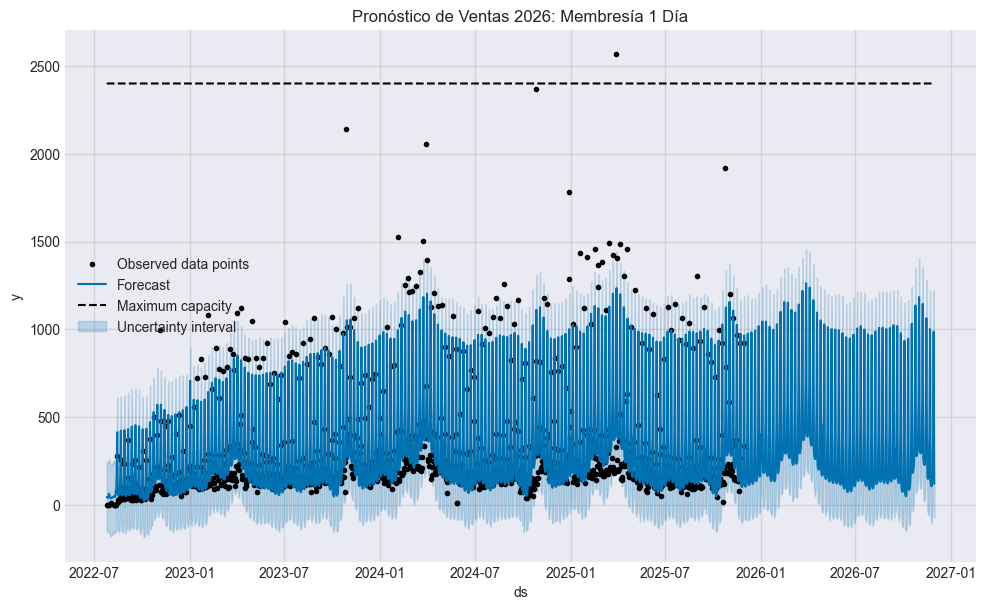

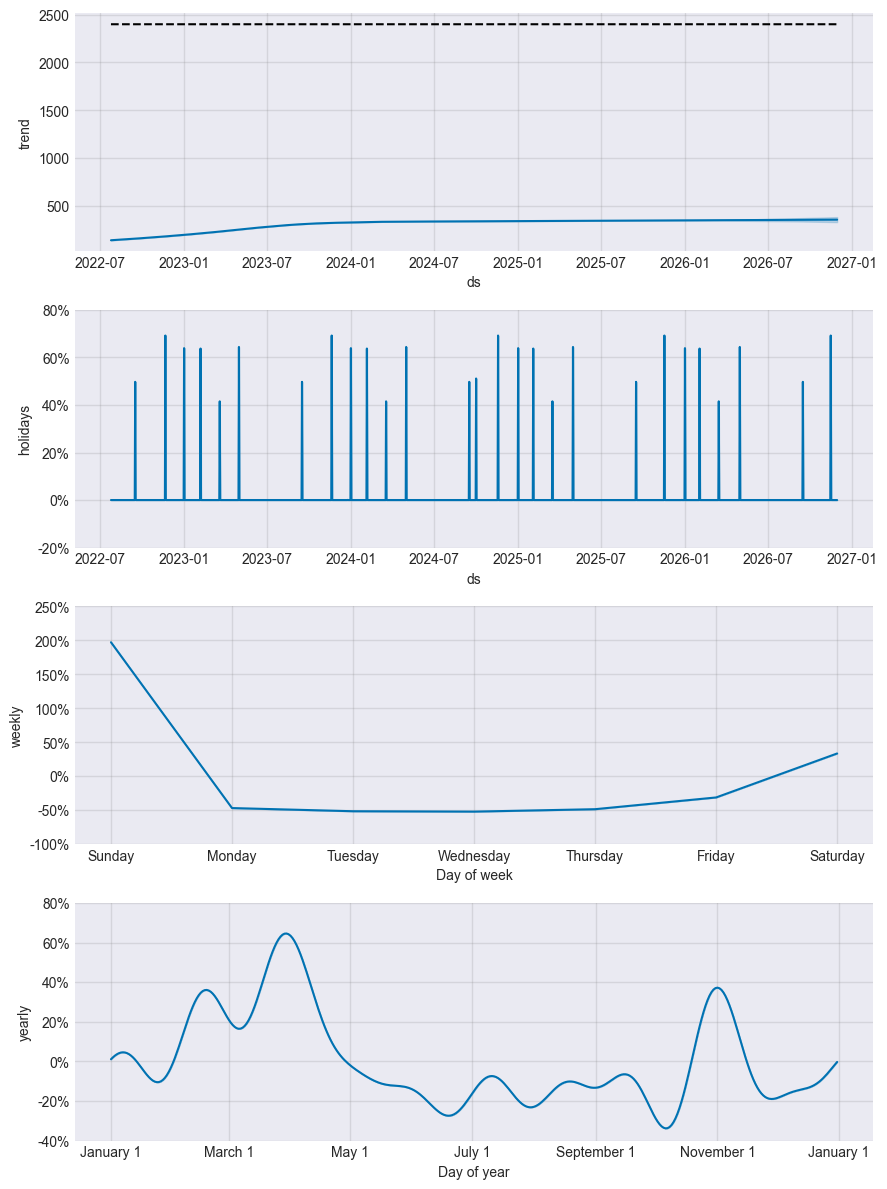

In [326]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [327]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month     yhat  yhat_lower  yhat_upper
0   2022-07    150.0      -452.0       748.0
1   2022-08   2860.0     -2056.0      7635.0
2   2022-09   4055.0     -1935.0     10161.0
3   2022-10   5174.0     -1071.0     11376.0
4   2022-11   5527.0      -463.0     11524.0
5   2022-12   5075.0     -1145.0     11285.0
6   2023-01   6415.0       159.0     12599.0
7   2023-02   7606.0      1974.0     13167.0
8   2023-03   9501.0      3257.0     15726.0
9   2023-04   9939.0      3934.0     15940.0
10  2023-05   7022.0       780.0     13172.0
11  2023-06   6145.0       178.0     12155.0
12  2023-07   8138.0      1909.0     14348.0
13  2023-08   7452.0      1227.0     13686.0
14  2023-09   8273.0      2249.0     14354.0
15  2023-10   9449.0      3211.0     15783.0
16  2023-11  10052.0      4114.0     16098.0
17  2023-12   9471.0      3301.0     15805.0
18  2024-01   9606.0      3369.0     15805.0
19  2024-02  11905.0      6116.0     17765.0
20  2024-03  15023.0      8809.0     21231.0
21  2024-0

In [328]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [329]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]16:57:22 - cmdstanpy - INFO - Chain [1] start processing
16:57:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]16:57:23 - cmdstanpy - INFO - Chain [1] start processing
16:57:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

  horizon        rmse      mape
0  9 days   81.360588  0.295499
1 10 days   96.527757  0.287309
2 11 days  102.986473  0.280560
3 12 days  104.112983  0.276989
4 13 days  107.404482  0.289333
